## Image Captioning
- Generating Captions for Images

### Steps 
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import Add
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [8]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [9]:
captions  = readTextFile("./Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [10]:
captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [11]:
print(len(captions))

40460


In [12]:
first,second  = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


#### Dictionary to Map each Image with the list of captions it has

In [13]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [14]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

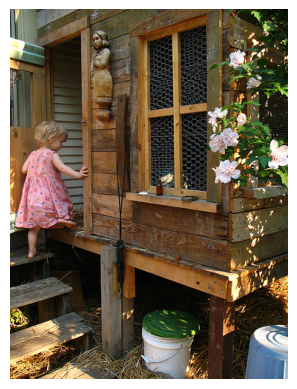

In [15]:
IMG_PATH = "Data/Images/"
import cv2 as cv
import matplotlib.pyplot as plt

img = cv.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
# img
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()



### Data Cleaning


In [16]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [17]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [18]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [19]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [20]:
# Write the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary 

In [21]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [22]:
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with p

In [23]:
print(type(descriptions))

<class 'dict'>


In [28]:
descriptions['1016887272_03199f49c4'][0].split()

['collage', 'of', 'one', 'person', 'climbing', 'cliff']

In [25]:
# We split the words of each sentence for each image, and insert them into a set to form a vocabulary

vocab = set()
for key in descriptions.keys():
    for sentence in descriptions[key]:
        [vocab.update(sentence.split())]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [32]:
# Total No of words across all the sentences

total_words = []

for key in descriptions.keys():
    for sentence in descriptions[key]:
        for i in sentence.split():
            [total_words.append(i)]
    
print("Total Words %d"%len(total_words))

Total Words 373837


### Filter Words from the Vocab according to certain threshold frequncy

In [34]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))
# print(freq_cnt)

8424


In [39]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
# print(sorted_freq_cnt)

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
print(sorted_freq_cnt)

[('in', 18987), ('the', 18420), ('on', 10746), ('is', 9345), ('and', 8863), ('dog', 8138), ('with', 7765), ('man', 7275), ('of', 6723), ('two', 5643), ('white', 3959), ('black', 3848), ('boy', 3581), ('are', 3505), ('woman', 3403), ('girl', 3328), ('to', 3176), ('wearing', 3062), ('at', 2916), ('people', 2887), ('water', 2790), ('red', 2691), ('young', 2630), ('brown', 2578), ('an', 2432), ('his', 2357), ('blue', 2279), ('dogs', 2125), ('running', 2073), ('through', 2032), ('playing', 2008), ('while', 1968), ('shirt', 1962), ('down', 1843), ('standing', 1789), ('ball', 1783), ('little', 1768), ('grass', 1622), ('snow', 1547), ('child', 1545), ('person', 1542), ('jumping', 1473), ('over', 1415), ('three', 1389), ('front', 1386), ('sitting', 1368), ('holding', 1324), ('up', 1302), ('field', 1283), ('small', 1278), ('by', 1249), ('large', 1237), ('green', 1234), ('one', 1223), ('group', 1218), ('yellow', 1217), ('her', 1178), ('walking', 1165), ('children', 1156), ('men', 1121), ('into', 

In [40]:
total_words = [x[0] for x in sorted_freq_cnt]
print(len(total_words))

1845


### Prepare Train/Test Data

In [41]:
train_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [42]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [43]:
train

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154',
 '2851304910_b5721199bc',
 '3423802527_94bd2b23b0',
 '3356369156_074750c6cc',
 '2294598473_40637b5c04',
 '1191338263_a4fa073154',
 '2380765956_6313d8cae3',
 '3197891333_b1b0fd1702',
 '3119887967_271a097464',
 '2276499757_b44dc6f8ce',
 '2506892928_7e79bec613',
 '2187222896_c206d63396',
 '2826769554_85c90864c9',
 '3097196395_ec06075389',
 '3603116579_4a28a932e2',
 '3339263085_6db9fd0981',
 '2532262109_87429a2cae',
 '2076906555_c20dc082db',
 '2502007071_82a8c639cf',
 '3113769557_9edbb8275c',
 '3325974730_3ee192e4ff',
 '1655781989_b15ab4cbff',
 '1662261486_db967930de',
 '2410562803_56ec09f41c',
 '2469498117_b4543e1460',
 '69710415_5c2bfb1058',
 '3414734842_beb543f400',
 '3006217970_90b42e6b27',
 '2192411521_9c7e488c5e',
 '3535879138_928

In [44]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for sentence in descriptions[img_id]:
        sentence_to_append = "startseq "  + sentence + " endseq"
        train_descriptions[img_id].append(sentence_to_append)

In [45]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Step - 1 Image Feature Extraction

In [46]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [49]:
# We will extract the features of the images from the second last layer of the model, rather than the last layer which 
# specifically contains the probabilities of different classes.
model_new = Model(model.input,model.layers[-2].output)

In [48]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


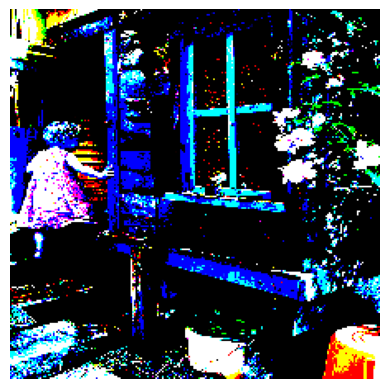

In [61]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [51]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    print(feature_vector.shape)
    return feature_vector

In [52]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 1s 720ms/step
(2048,)


array([0.06536563, 0.16782703, 0.32518458, ..., 0.05111529, 0.32817894,
       1.0043341 ], dtype=float32)

In [ ]:
start = time()
encoding_train = {}  

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path) #img_id --> feature_vector extracted from Resnet Image
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

1/1 [==============================] - 0s 164ms/step
Encoding in Progress Time step 0 
1/1 [==============================] - 0s 181ms/step
Encoding in Progress Time step 100 
1/1 [==============================] - 0s 183ms/step
Encoding in Progress Time step 200 
1/1 [==============================] - 0s 199ms/step
Encoding in Progress Time step 300 
1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 190ms/step
Encoding in Progress Time step 400 
1/1 [==============================] - 0s 202ms/step


1/1 [==============================] - 0s 206ms/step
Encoding in Progress Time step 500 
1/1 [==============================] - 0s 213ms/step
Encoding in Progress Time step 600 
1/1 [==============================] - 0s 214ms/step
Encoding in Progress Time step 700 
1/1 [==============================] - 0s 230ms/step


1/1 [==============================] - 0s 222ms/step
Encoding in Progress Time step 800 
1/1 [==============================] - 0s 234ms/step
Encoding in Progress Time step 900 
1/1 [==============================] - 0s 246ms/step
Encoding in Progress Time step 1000 
1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 281ms/step
Encoding in Progress Time step 1100 
1/1 [==============================] - 0s 310ms/step
Encoding in Progress Time step 1200 
1/1 [==============================] - 0s 403ms/step
Encoding in Progress Time step 1300 
1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 439ms/step
Encoding in Progress Time step 1400 
1/1 [==============================] - 0s 408ms/step
Encoding in Progress Time step 1500 
1/1 [==============================] - 0s 378ms/step
Encoding in Progress Time step 1600 
1/1 [==============================] - 0s 414ms/step


1/1 [==============================] - 0s 406ms/step
Encoding in Progress Time step 1700 
1/1 [==============================] - 0s 406ms/step
Encoding in Progress Time step 1800 
1/1 [==============================] - 0s 433ms/step
Encoding in Progress Time step 1900 
1/1 [==============================] - 0s 445ms/step


1/1 [==============================] - 0s 437ms/step
Encoding in Progress Time step 2000 
1/1 [==============================] - 0s 462ms/step
Encoding in Progress Time step 2100 
1/1 [==============================] - 0s 445ms/step
Encoding in Progress Time step 2200 
1/1 [==============================] - 0s 453ms/step
Encoding in Progress Time step 2300 


1/1 [==============================] - 0s 412ms/step
Encoding in Progress Time step 2400 
1/1 [==============================] - 0s 496ms/step


1/1 [==============================] - 0s 474ms/step
Encoding in Progress Time step 2500 
1/1 [==============================] - 0s 497ms/step
Encoding in Progress Time step 2600 
1/1 [==============================] - 0s 464ms/step
Encoding in Progress Time step 2700 
1/1 [==============================] - 0s 443ms/step


1/1 [==============================] - 0s 458ms/step
Encoding in Progress Time step 2800 
1/1 [==============================] - 0s 487ms/step
Encoding in Progress Time step 2900 
1/1 [==============================] - 0s 492ms/step
Encoding in Progress Time step 3000 
1/1 [==============================] - 1s 516ms/step


1/1 [==============================] - 1s 521ms/step
Encoding in Progress Time step 3100 
1/1 [==============================] - 1s 509ms/step
Encoding in Progress Time step 3200 
1/1 [==============================] - 1s 550ms/step
Encoding in Progress Time step 3300 
1/1 [==============================] - 1s 513ms/step


1/1 [==============================] - 1s 525ms/step
Encoding in Progress Time step 3400 
1/1 [==============================] - 1s 752ms/step
Encoding in Progress Time step 3500 
1/1 [==============================] - 1s 584ms/step
Encoding in Progress Time step 3600 
1/1 [==============================] - 1s 555ms/step


1/1 [==============================] - 1s 564ms/step
Encoding in Progress Time step 3700 
1/1 [==============================] - 1s 572ms/step
Encoding in Progress Time step 3800 
1/1 [==============================] - 1s 605ms/step
Encoding in Progress Time step 3900 
1/1 [==============================] - 1s 506ms/step


1/1 [==============================] - 1s 533ms/step
Encoding in Progress Time step 4000 
1/1 [==============================] - 1s 588ms/step
Encoding in Progress Time step 4100 
1/1 [==============================] - 1s 530ms/step
Encoding in Progress Time step 4200 
1/1 [==============================] - 1s 523ms/step


In [ ]:
!mkdir saved

In [ ]:
# Store everything to the disk 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
start = time()
encoding_test = {}

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

In [ ]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### Data pre-processing for Captions

In [ ]:
# Vocab
len(total_words)

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [ ]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

In [ ]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

In [ ]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

### Data Loader (Generator)

In [ ]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

## Word Embeddings 

In [ ]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [ ]:
f.close()

In [ ]:
embedding_index['apple']

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        
    

In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

#### Model Architecture

In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [ ]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
decoder1 = Add()([inp_img2, inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [ ]:
model.summary()

In [ ]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Training of Model

In [ ]:
len(train_descriptions)

In [ ]:
encoding_train

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [ ]:
print('2513260012_03d33305cf.jpg' in encoding_train)

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

In [ ]:
model = load_model('./model_weights/model_9.h5')

## Predictions

In [ ]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [ ]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    